In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from pickle import dump
print(f'Running Tensoflow {tf.__version__}')

Running Tensoflow 2.10.0


In [2]:
# Load data
BTSettl = pd.read_csv('..\data\BT-Settl_all_Myr_Gaia+2MASS+PanSTARRS.csv')
inputs = ['age_Myr', 'M/Ms']
targets = ['Li', 'G', 'G_BP', 'G_RP', 'J', 'H', 'K', 'g_p1', 'r_p1', 'i_p1', 'y_p1', 'z_p1']
X = np.array(BTSettl[inputs])
Y = np.array(BTSettl[targets])

# Split into train and test datasets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, shuffle = True)

# Normalize data
BoxCox = PowerTransformer(method='box-cox', standardize=False).fit(X_train)
X_train = BoxCox.transform(X_train)
X_test = BoxCox.transform(X_test)
MinMax = MinMaxScaler().fit(X_train)
X_train = MinMax.transform(X_train)
X_test = MinMax.transform(X_test)
scalers = [BoxCox, MinMax]

# Split outputs
Li_train = Y_train[:, 0]
Li_test = Y_test[:, 0]
Pho_train = Y_train[:, 1:]
Pho_test = Y_test[:, 1:]

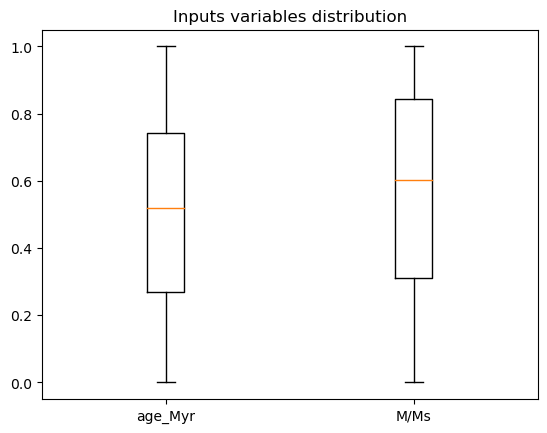

In [3]:
plt.title('Inputs variables distribution')
plt.boxplot(X_train, labels=['age_Myr', 'M/Ms'])
plt.show()

In [4]:
# Define Neural Network: structure, activation, initializers, etc.
inputs = layers.Input(shape = (2,), name = 'Age, Mass')
dense = layers.Dense(
    units = 64, 
    activation = "relu", 
    kernel_initializer = keras.initializers.HeNormal(),
    # kernel_regularizer = keras.regularizers.L2(0.01),
    bias_initializer = keras.initializers.Zeros(),
    name = 'HL1')(inputs)
dense = layers.Dense(
    units = 64, 
    activation = "relu", 
    kernel_initializer = keras.initializers.HeNormal(),
    # kernel_regularizer = keras.regularizers.L2(0.01),
    bias_initializer = keras.initializers.Zeros(),
    name = 'HL2')(dense)
dense = layers.Dense(
    units = 64, 
    activation = "relu", 
    kernel_initializer = keras.initializers.HeNormal(),
    # kernel_regularizer = keras.regularizers.L2(0.01),
    bias_initializer = keras.initializers.Zeros(),
    name = 'HL3')(dense)
Li = layers.Dense(
    units = 1,
    activation = 'sigmoid',
    kernel_initializer = keras.initializers.GlorotNormal(),
    # use_bias = False,
    name = 'Li')(dense)
Photometry = layers.Dense(
    units = 11,
    # kernel_regularizer = keras.regularizers.L2(0.01),
    # bias_regularizer = keras.regularizers.L2(0.01),
    name = 'Photometry')(dense)

In [5]:
# Implementation of ALI-G in tensorflow 2
class AliG(tf.keras.optimizers.SGD):
    """Optimizer that implements the AliG algorithm.
    """

    def __init__(self, max_lr=None, momentum=0.0, name="AliG", eps=1e-5):
        super(AliG, self).__init__(
            learning_rate=1.0,
            name=name,
            momentum=momentum,
            nesterov=bool(momentum),
          )
        self._set_hyper("max_lr", max_lr if max_lr is not None else 0.0)
        self._set_hyper("eps", eps)

    def minimize(self, loss, var_list, grad_loss=None, name=None, tape=None):
        # first part of method is identical to tf
        grads_and_vars = self._compute_gradients(
            loss, var_list=var_list, tape=tape, grad_loss=grad_loss)

        # compute learning-rate here
        grad_sqrd_norm = sum(tf.norm(grad) ** 2 for grad, _ in grads_and_vars)
        learning_rate = loss / (grad_sqrd_norm + self._get_hyper("eps"))

        max_lr = self._get_hyper("max_lr")

        learning_rate = tf.cond(
            max_lr > 0.0,
            lambda: tf.clip_by_value(
                learning_rate,
                clip_value_min=0,
                clip_value_max=max_lr),
            lambda: learning_rate,
        )

        grads_and_vars = [(g * learning_rate, v) for g, v in grads_and_vars]

        return self.apply_gradients(grads_and_vars, name=name)
optimizer = AliG(max_lr=0.1) # , momentum=0.7

In [6]:
# Define Huber loss
huber = keras.losses.Huber()

# Define Mean Squared Error loss
mse = keras.losses.MeanSquaredError()

# Define Mean Absolute Error loss
msa = keras.losses.MeanAbsoluteError()

# Define custom loss
def custom_loss(y_true, y_pred):
    '''Increase the loss by a factor'''
    alpha = 2.0
    return alpha*mse(y_true, y_pred)

In [7]:
# Set metrics
RMSE = keras.metrics.RootMeanSquaredError()

In [8]:
# Instanciate and compile model
model = keras.Model(inputs = inputs, outputs = [Li, Photometry], name = 'BTSettl')
model.compile(optimizer=optimizer, loss = {'Li' : msa, 'Photometry' : mse}, metrics=[RMSE]) 

In [9]:
model.summary()

Model: "BTSettl"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Age, Mass (InputLayer)         [(None, 2)]          0           []                               
                                                                                                  
 HL1 (Dense)                    (None, 64)           192         ['Age, Mass[0][0]']              
                                                                                                  
 HL2 (Dense)                    (None, 64)           4160        ['HL1[0][0]']                    
                                                                                                  
 HL3 (Dense)                    (None, 64)           4160        ['HL2[0][0]']                    
                                                                                            

In [10]:
# Define early stopping feature from keras
# early_stop = keras.callbacks.EarlyStopping(monitor = 'loss', min_delta = 0.01, patience = 300, mode = 'min', restore_best_weights = True)

In [11]:
history = model.fit(X_train, [Li_train, Pho_train], epochs=10000, batch_size = 16, validation_data=(X_test, [Li_test, Pho_test]), verbose=0)
# , callbacks = [early_stop]

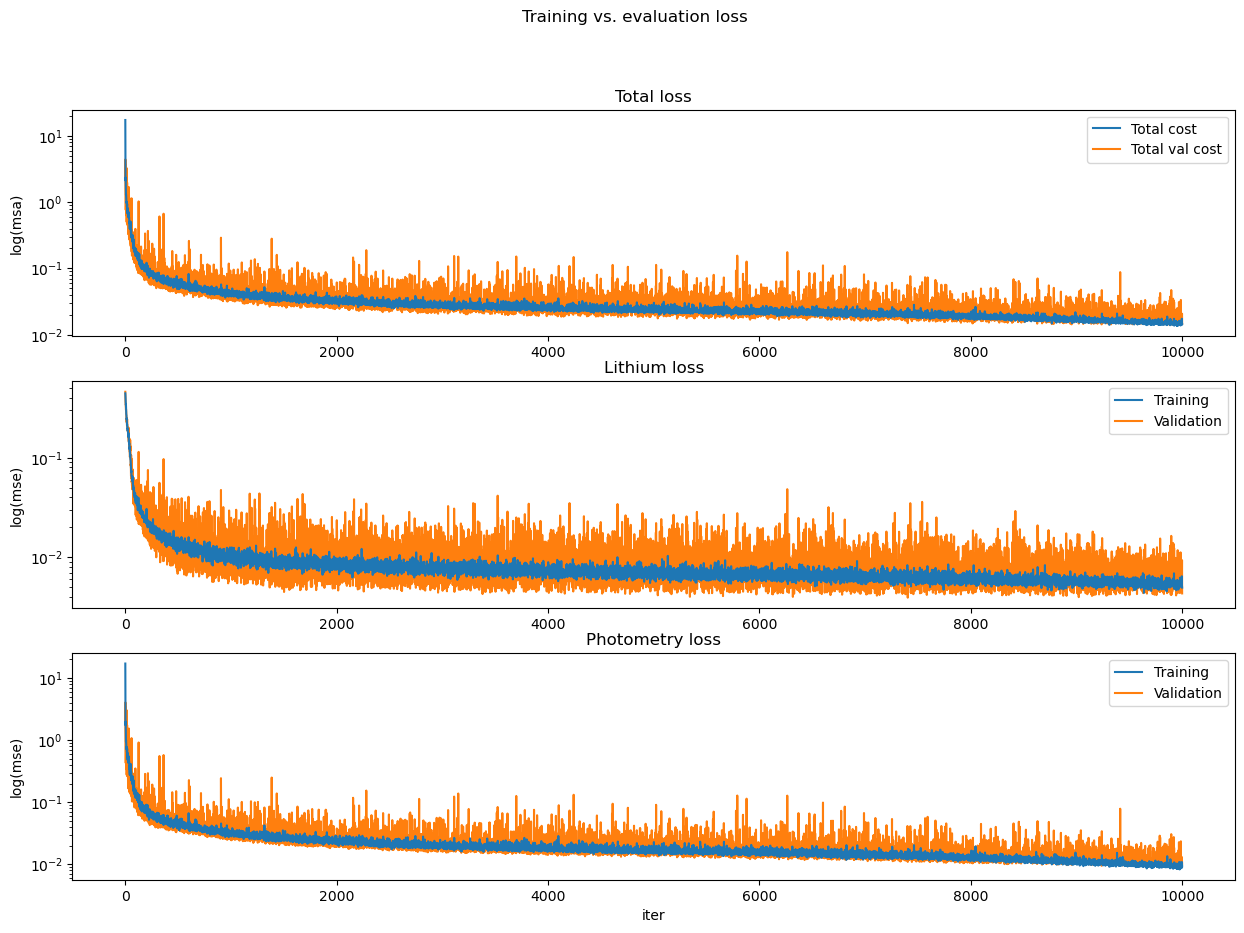

In [12]:
# Plot loss vs. iter
loss = history.history['loss']
val = history.history['val_loss']
Li_loss = history.history['Li_loss']
Li_val = history.history['val_Li_loss']
Photometry_loss = history.history['Photometry_loss']
Photometry_val = history.history['val_Photometry_loss']
iters = range(len(loss))

fig, axs = plt.subplots(3, 1, figsize=(15, 10))
fig.suptitle('Training vs. evaluation loss')
axs[0].set_title('Total loss')
axs[0].set_ylabel('log(msa)')
axs[0].plot(iters, loss, label = 'Total cost', zorder= 1)
axs[0].plot(iters, val, label = 'Total val cost', zorder= 0)
axs[0].set_yscale('log')
axs[0].legend()
axs[1].set_title('Lithium loss')
axs[1].plot(iters, Li_loss, label = 'Training', zorder= 1)
axs[1].plot(iters, Li_val, label = 'Validation', zorder= 0)
axs[1].legend()
axs[1].set_yscale('log')
axs[1].set_ylabel('log(mse)')
axs[2].set_title('Photometry loss')
axs[2].plot(iters, Photometry_loss, label = 'Training', zorder= 1)
axs[2].plot(iters, Photometry_val, label = 'Validation', zorder= 0)
axs[2].set_xlabel('iter')
axs[2].set_ylabel('log(mse)')
axs[2].set_yscale('log')
axs[2].legend()
plt.show()


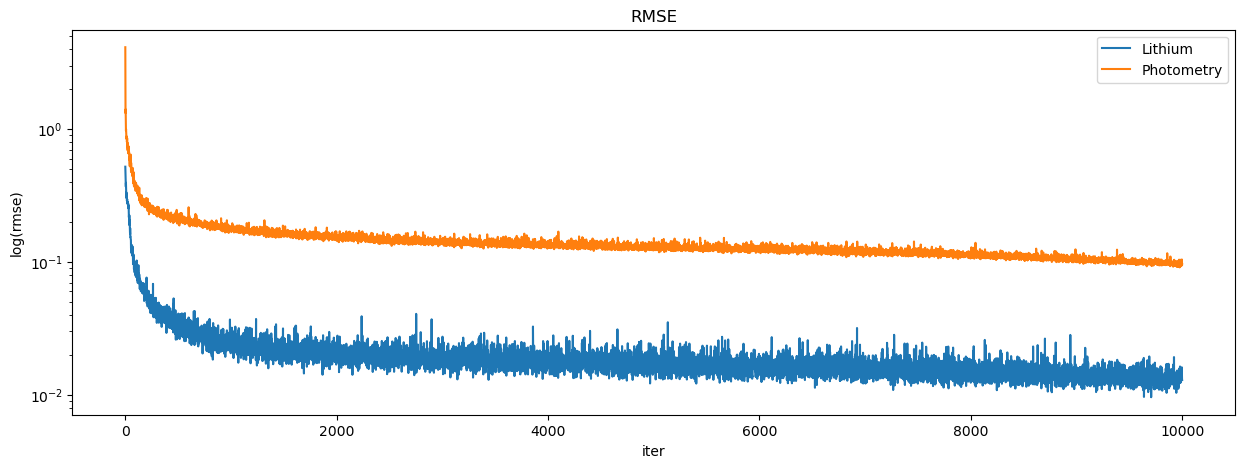

In [13]:
# Plot RMSE vs. iter
Li_rmse = history.history['Li_root_mean_squared_error']
Photometry_rmse = history.history['Photometry_root_mean_squared_error']
iters = range(len(Li_rmse))

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.set_title('RMSE')
ax.plot(iters, Li_rmse, label = 'Lithium')
ax.legend()
ax.set_ylabel('log(rmse)')
ax.plot(iters, Photometry_rmse, label = 'Photometry')
ax.set_xlabel('iter')
ax.set_yscale('log')
ax.legend()
plt.show()

In [14]:
# Evaluate model
model.evaluate(X_test, [Li_test, Pho_test], batch_size = 16) # , callbacks = [early_stop])

11/11 [==============================] - 0s 3ms/step - loss: 0.0145 - Li_loss: 0.0043 - Photometry_loss: 0.0102 - Li_root_mean_squared_error: 0.0116 - Photometry_root_mean_squared_error: 0.1009


[0.014519576914608479,
 0.004331130068749189,
 0.010188446380198002,
 0.01161981001496315,
 0.10093783587217331]

In [15]:
test_preds = model.predict(X_test)
train_preds = model.predict(X_train)

21/21 [==============================] - 0s 2ms/step


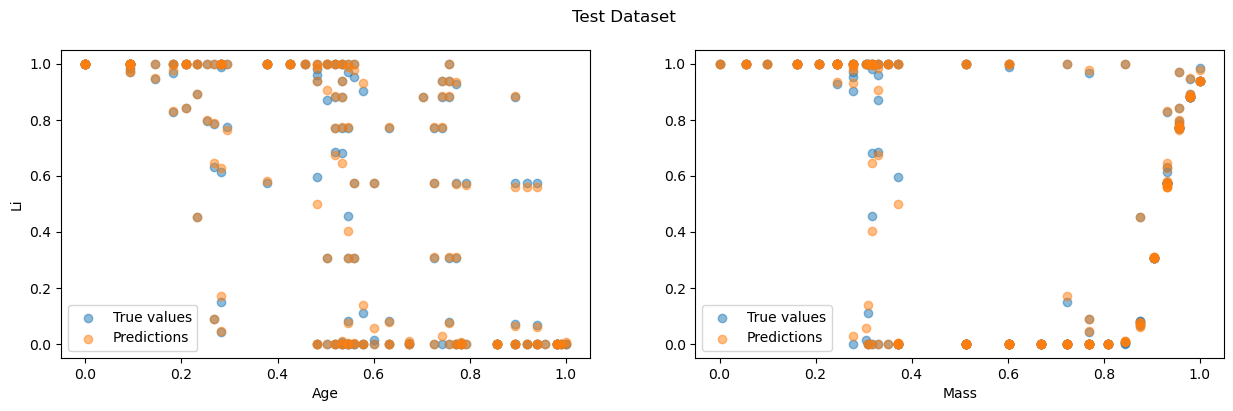

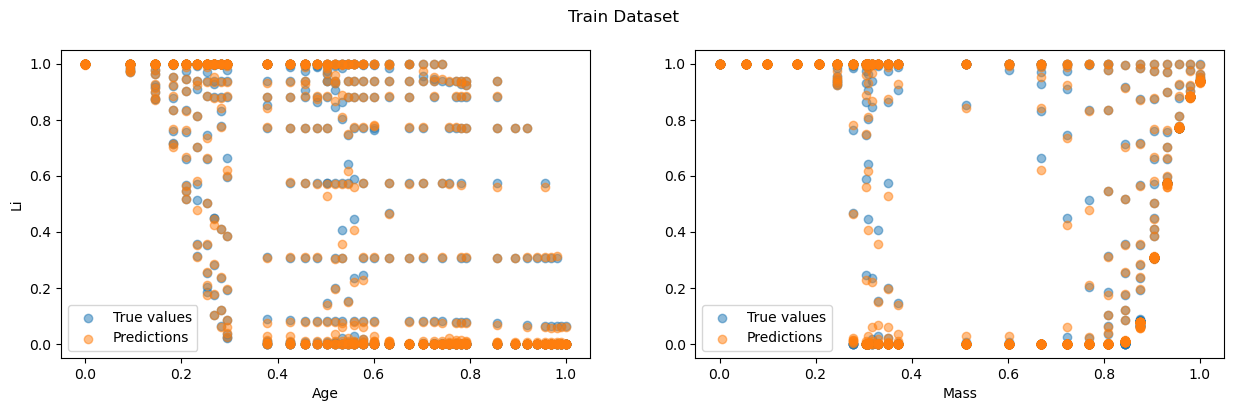

In [16]:
# Model evaluation
o = 0.5 # Opacity
# Lithium
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Test Dataset')
axs[0].scatter(X_test[:, 0], Li_test, alpha = o, label = 'True values')
axs[0].scatter(X_test[:, 0], test_preds[0], alpha = o, label = 'Predictions')
axs[0].set_xlabel('Age')
axs[0].set_ylabel(targets[0])
axs[0].legend()
axs[1].scatter(X_test[:, 1], Li_test, alpha = o, label = 'True values')
axs[1].scatter(X_test[:, 1], test_preds[0][:, 0], alpha = o, label = 'Predictions')
axs[1].set_xlabel('Mass')
axs[1].legend()
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Train Dataset')
axs[0].scatter(X_train[:, 0], Li_train, alpha = o, label = 'True values')
axs[0].scatter(X_train[:, 0], train_preds[0], alpha = o, label = 'Predictions')
axs[0].set_xlabel('Age')
axs[0].set_ylabel(targets[0])
axs[0].legend()
axs[1].scatter(X_train[:, 1], Li_train, alpha = o, label = 'True values')
axs[1].scatter(X_train[:, 1], train_preds[0][:, 0], alpha = o, label = 'Predictions')
axs[1].set_xlabel('Mass')
axs[1].legend()
plt.show()

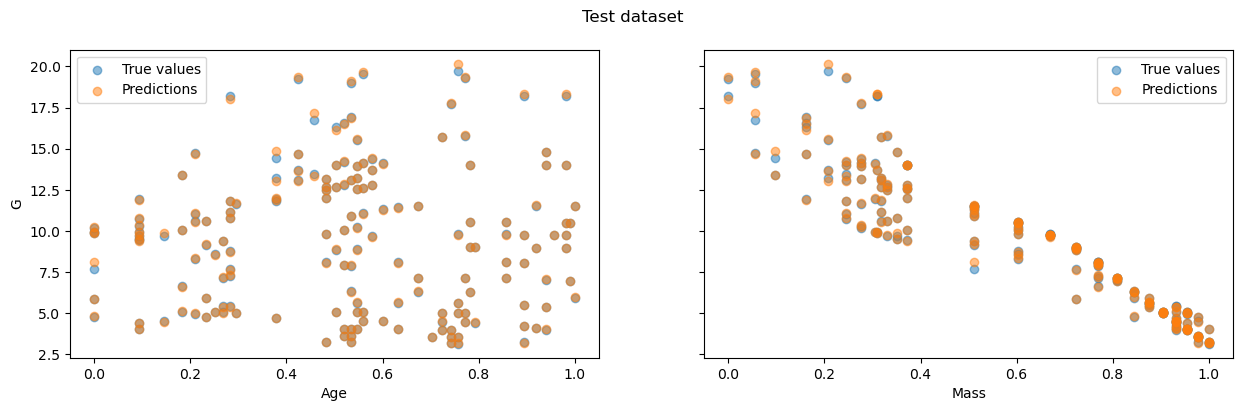

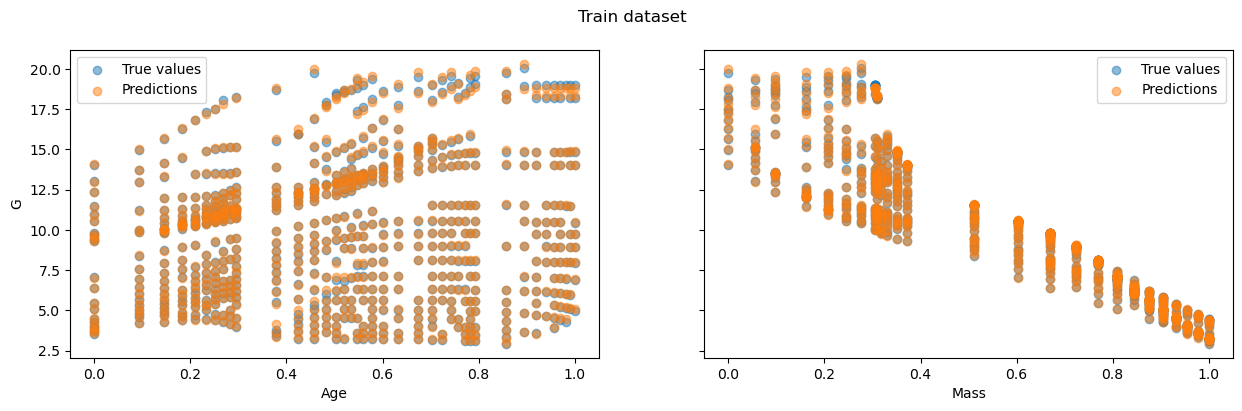

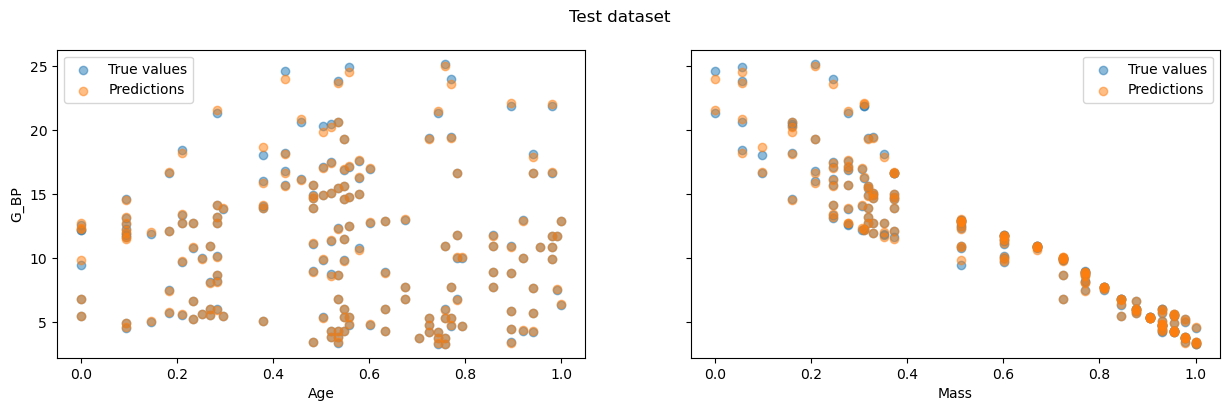

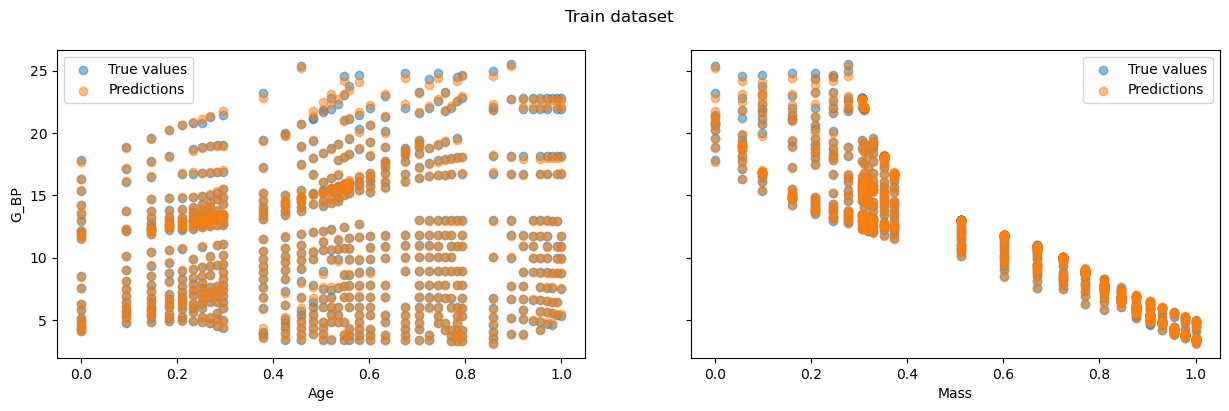

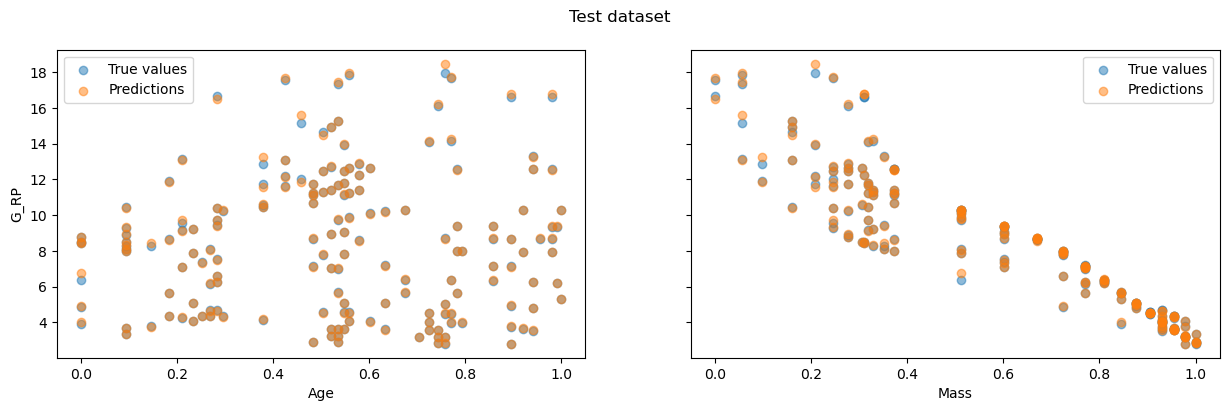

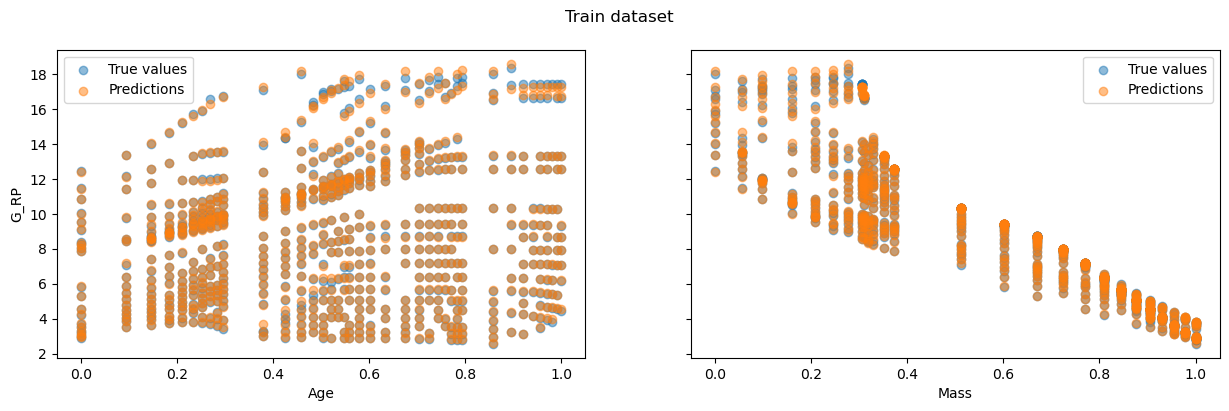

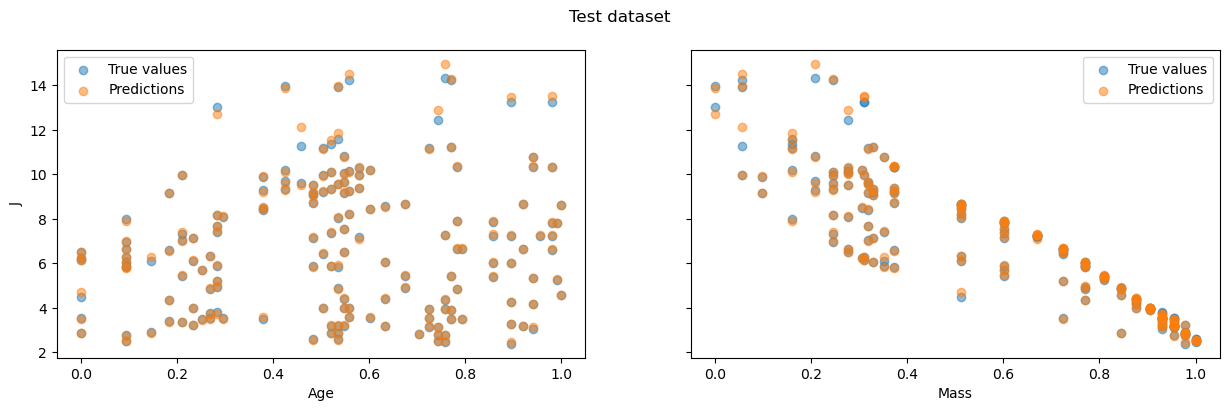

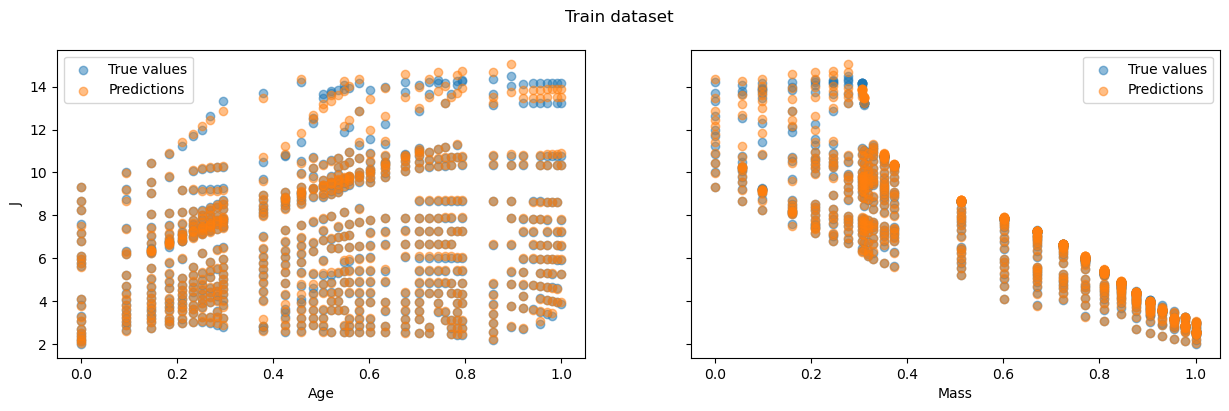

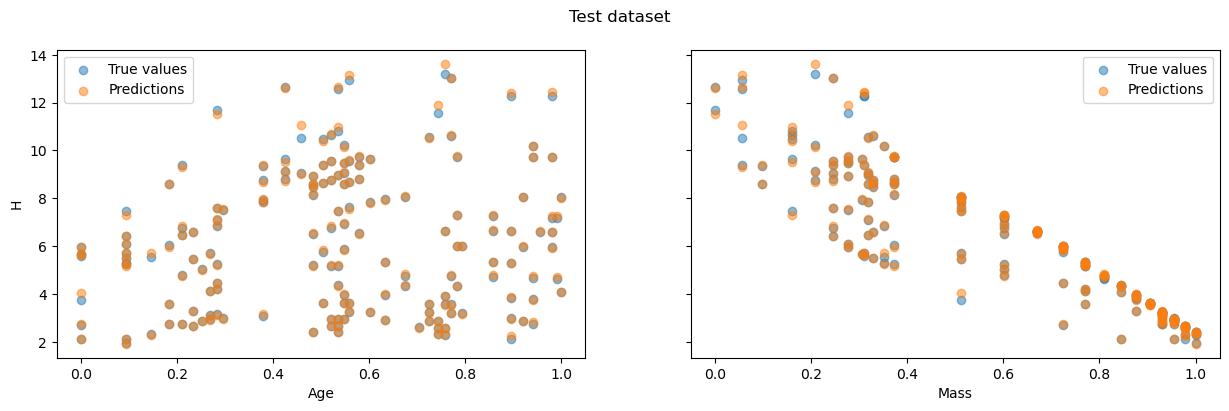

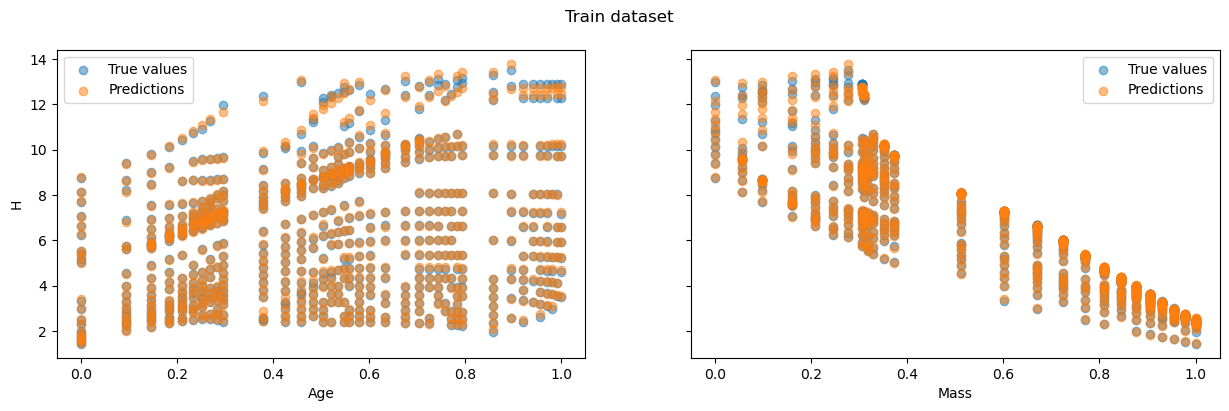

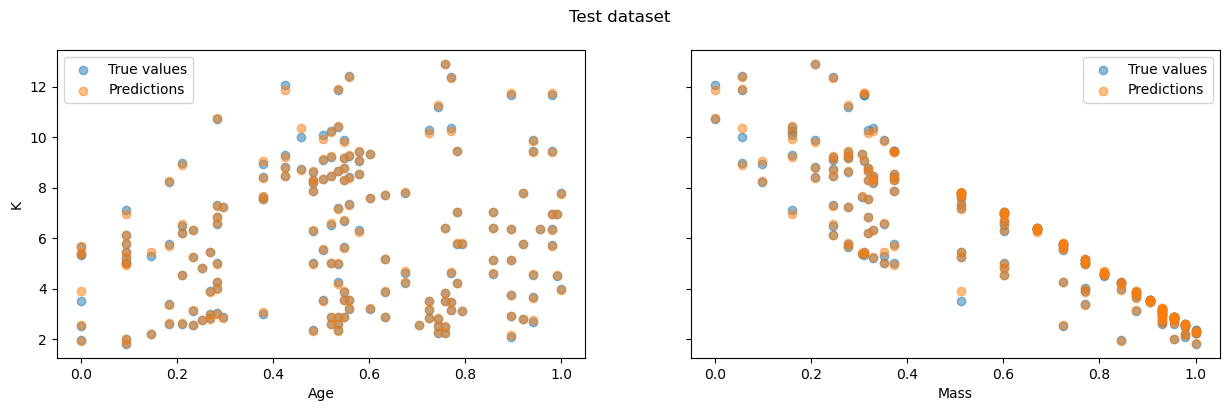

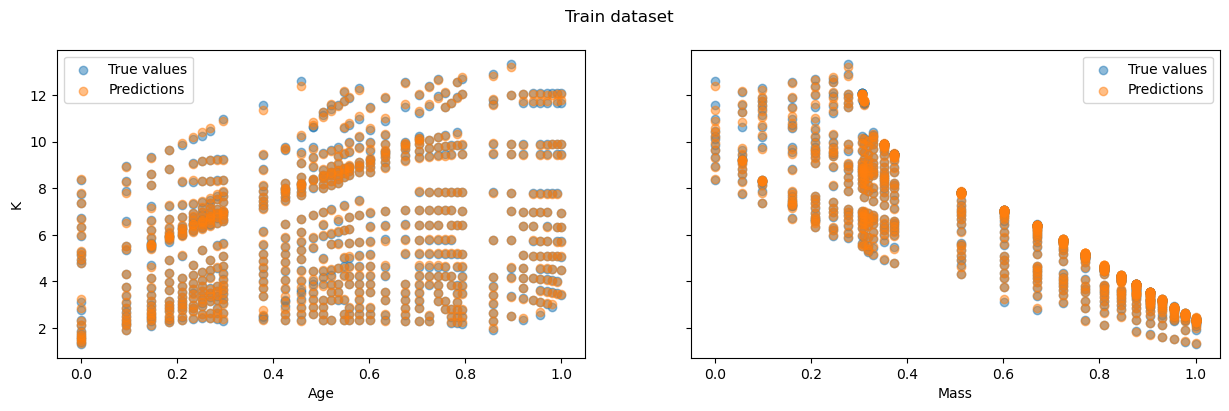

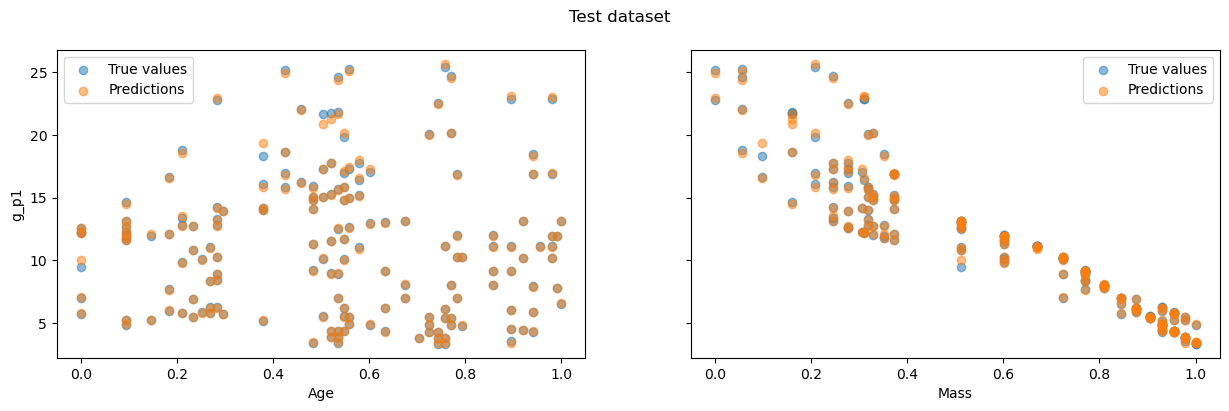

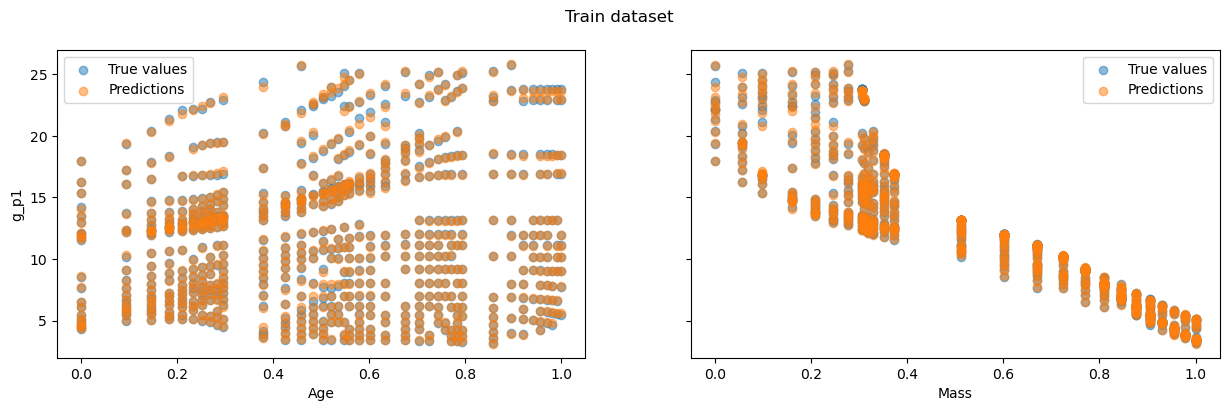

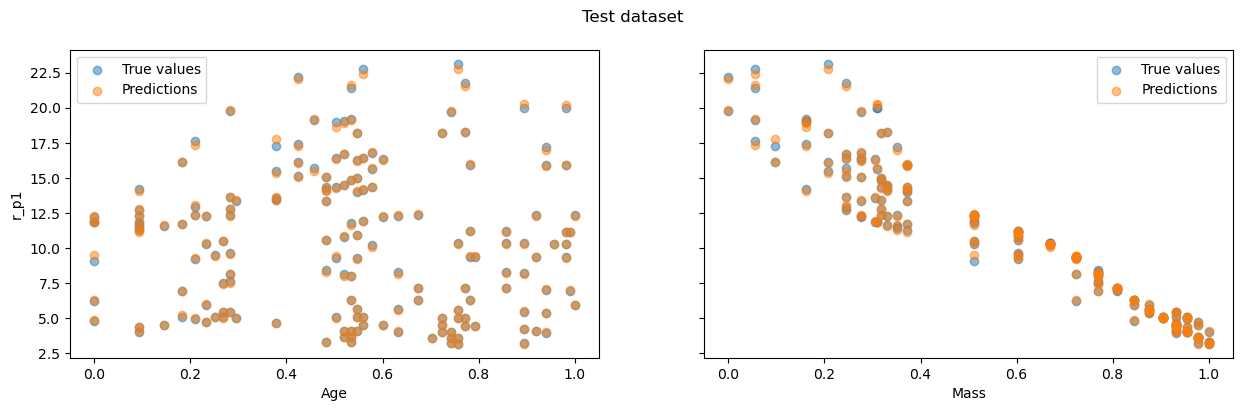

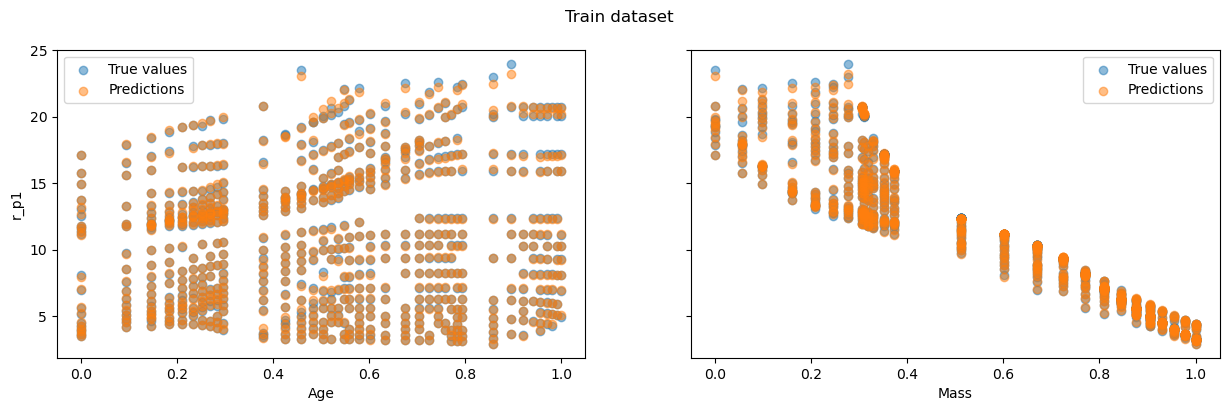

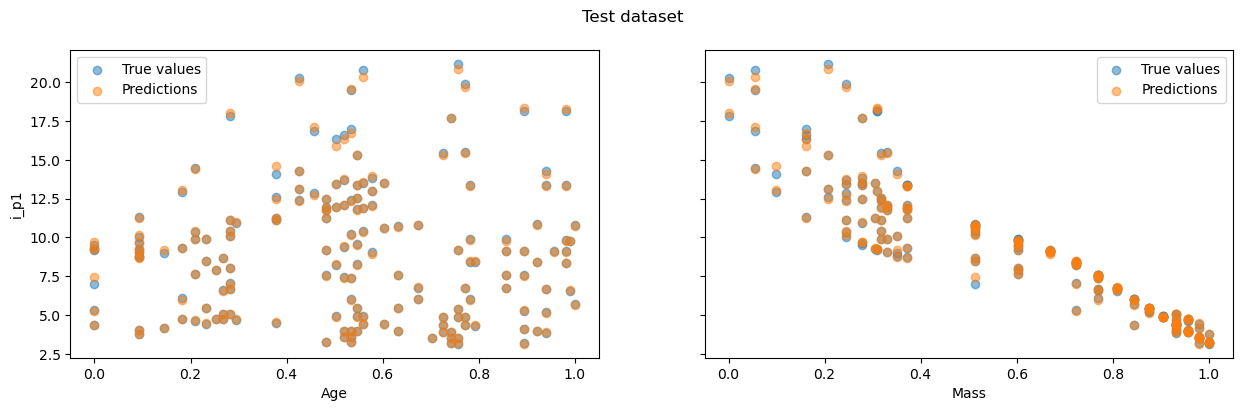

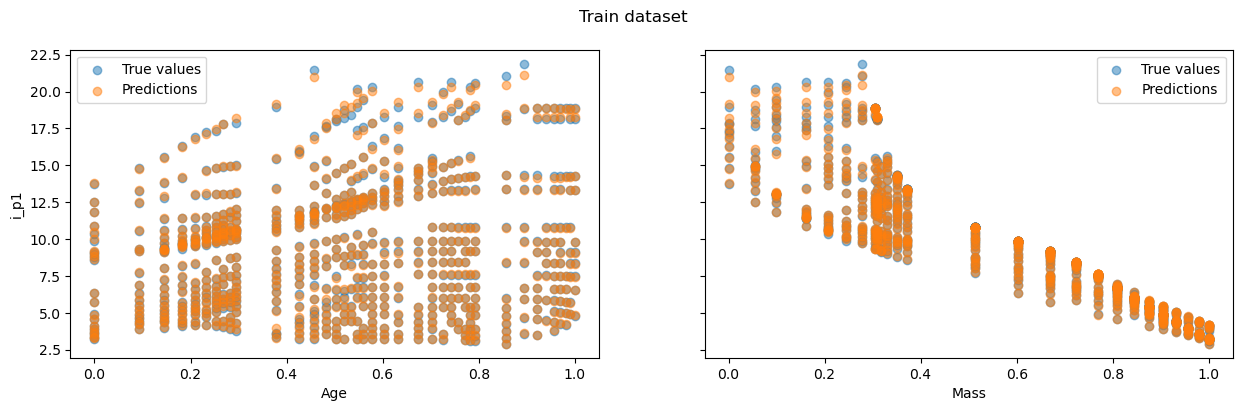

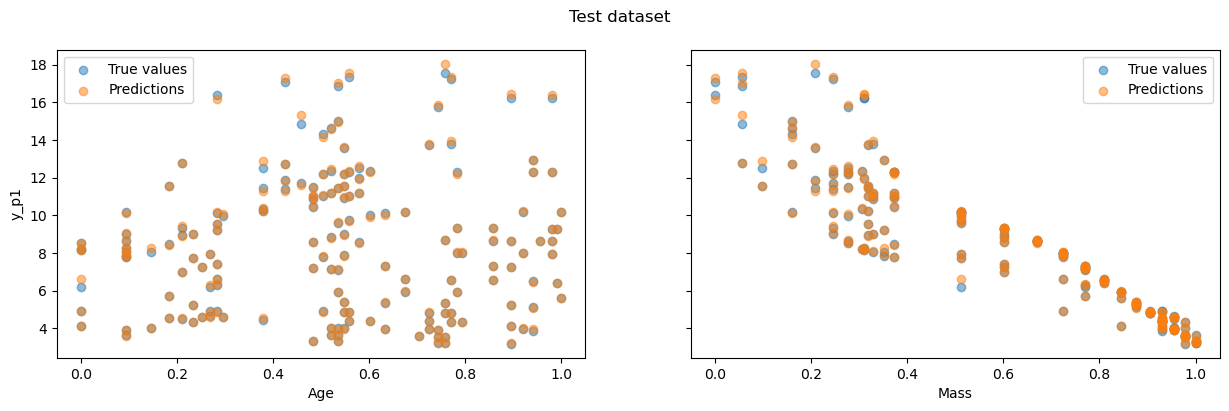

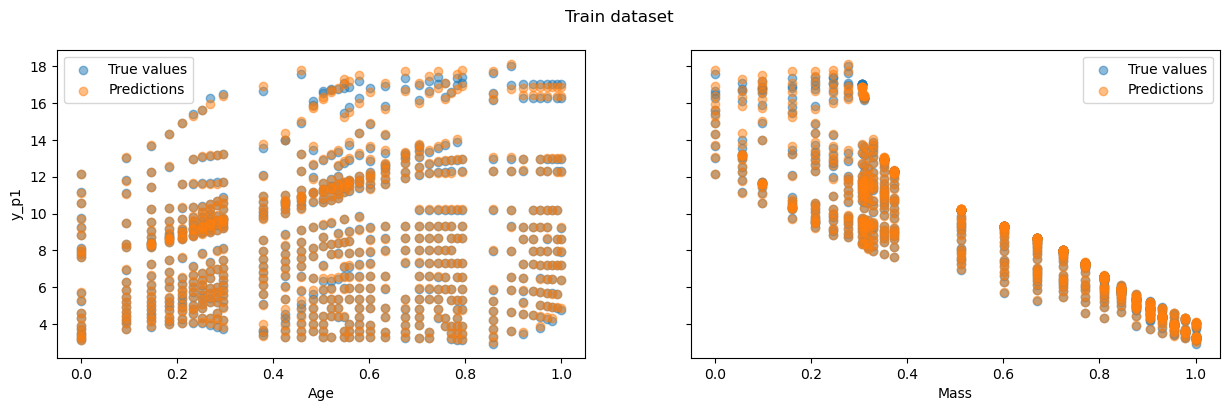

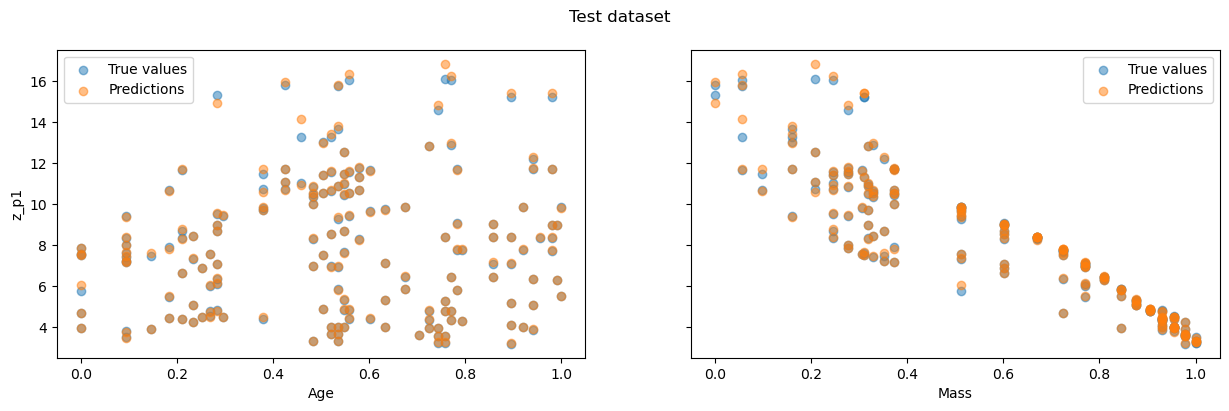

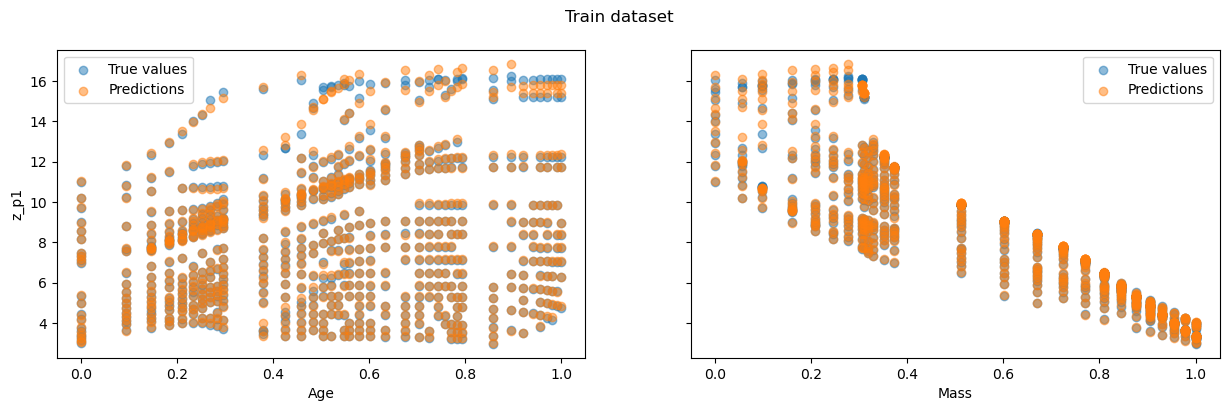

In [17]:
for i in range(test_preds[1].shape[1]):
    fig, axs = plt.subplots(1, 2, figsize=(15, 4), sharey=True)
    fig.suptitle('Test dataset')
    axs[0].scatter(X_test[:, 0], Pho_test[:, i], alpha = o, label = 'True values')
    axs[0].scatter(X_test[:, 0], test_preds[1][:, i], alpha = o, label = 'Predictions')
    axs[0].set_xlabel('Age')
    axs[0].set_ylabel(targets[i+1])
    axs[0].legend()
    axs[1].scatter(X_test[:, 1], Pho_test[:, i], alpha = o, label = 'True values')
    axs[1].scatter(X_test[:, 1], test_preds[1][:, i], alpha = o, label = 'Predictions')
    axs[1].set_xlabel('Mass')
    axs[1].legend()
    fig, axs = plt.subplots(1, 2, figsize=(15, 4), sharey=True)
    fig.suptitle('Train dataset')
    axs[0].scatter(X_train[:, 0], Pho_train[:, i], alpha = o, label = 'True values')
    axs[0].scatter(X_train[:, 0], train_preds[1][:, i], alpha = o, label = 'Predictions')
    axs[0].set_xlabel('Age')
    axs[0].set_ylabel(targets[i+1])
    axs[0].legend()
    axs[1].scatter(X_train[:, 1], Pho_train[:, i], alpha = o, label = 'True values')
    axs[1].scatter(X_train[:, 1], train_preds[1][:, i], alpha = o, label = 'Predictions')
    axs[1].set_xlabel('Mass')
    axs[1].legend()
    plt.show()

In [22]:
# Get optimal values
weights = model.get_weights()

# Save optimal values
dump(weights, open('weights.pkl', 'wb'))

In [23]:
# Save scalers
dump(scalers, open('scalers.pkl', 'wb'))

In [20]:
# Check weights correspondence
i = 0
for weight in weights:
    print(f'weights[{i}].shape = {weight.shape}')
    i+=1

weights[0].shape = (2, 64)
weights[1].shape = (64,)
weights[2].shape = (64, 64)
weights[3].shape = (64,)
weights[4].shape = (64, 64)
weights[5].shape = (64,)
weights[6].shape = (64, 1)
weights[7].shape = (1,)
weights[8].shape = (64, 11)
weights[9].shape = (11,)


In [21]:
# # Normalize data
# scaler = StandardScaler().fit(X)
# X = scaler.transform(X)

# # Split outputs data
# Li = Y[:, 0]
# Pho = Y[:, 1:]

# # Initialize the KFold class
# kfold = KFold(n_splits=5, shuffle=True)

# # Train and evaluate the model using cross-validation
# fold_loss_scores = []
# for train, test in kfold.split(X, Y):
#   # Fit the model on the training data
#   model.fit(X[train], [Li[train], Pho[train]], epochs=300, batch_size=32, verbose=0)
  
#   # Evaluate the model on the test data
#   scores = model.evaluate(X[test], [Li[test], Pho[test]], verbose=0)
#   fold_loss_scores.append(scores[0])
#   print("loss: %.4f - Li_loss: %.4f - Photometry_loss: %.4f" % (scores[0], scores[1], scores[2]))
# # Calculate the mean accuracy across all folds
# mean_loss = np.mean(fold_loss_scores)
# print("Mean loss: %.4f" % mean_loss)